In [54]:
import numpy as np
import RandomMatrix as rm
import matplotlib.pyplot as plt

In [55]:
# create png flag for saving figures
create_png = False

# the number of targets
n_values = [4, 6, 10, 20, 40, 80, 100, 200, 240, 400, 800, 1000]
n_values_np = np.array(n_values)

# the distribution of the targets
# 'normal' for normal distribution, 'uniform' for uniform distribution
distribution = 'uniform' # 'normal', 'uniform', 'cube', 'sphere', 'circle', 'student_t'

# which space dimension to use, totally experimental
space_dimension = 3

# 'correlated' for correlated matrices, 'uncorrelated' for uncorrelated matrices
# Note: Uncorrelated matrices are not yet supported in the MatrixInverseDistance3D class
correlated = True # True or False

# use a different exponent
exponent = -1 # -1 for inverse distance, -2 for inverse square distance, etc.
logarithmic = False # use logarithmic scaling in this case exponent is ignored
logscale = 0.05 # the scale of the logarithmic distribution

# hardcore is the minimum distance between targets
hardcore = 0.001 # minimum distance between targets, 0.0 means no

# is the ensemble scaled?
scaled = False

# the goe spacing range
goe_spacing_range = 2

# the sample size of the first simulation
sample_size_first = 10000
sample_strategy = 'n' # 'homogenous', 'nsqrt' or 'n'

# generare the sample sizes for each n
sample_values = []
for n in n_values:
    if sample_strategy == 'homogenous':
        sample_value = sample_size_first
    elif sample_strategy == 'nsqrt':
        sample_value = sample_size_first * np.sqrt( n_values[0] / n )
    elif sample_strategy == 'n':
        sample_value = sample_size_first * ( n_values[0] / n ) 
    else:
        raise ValueError("Unknown sample strategy: {}".format(sample_strategy))
    if sample_value < 1:
        sample_value = 1
    else:
        sample_value = int(sample_value)
    sample_values.append(sample_value)
    
print("N values:", n_values)
print("Sample values:", sample_values)

matrices = []
simulations = []
for n in n_values:
    #if correlated:
        # Create a correlated matrix using the MatrixInverseDistance3D class
        # Note: This class is designed for 3D distributions, so we use it for correlated matrices
    G = rm.MatrixInverseDistance(n, distribution=distribution, 
                                        scaled=scaled, 
                                        exponent=exponent,
                                        logarithmic=logarithmic, 
                                        logscale=logscale,
                                        hardcore=hardcore,
                                        dimension=space_dimension,
                                        correlated=correlated)
    #else:
        # Create an uncorrelated matrix using the MatrixUncorrelated class, only 
        # limited support for distributions
        # G = rm.MatrixUncorrelated(n, scaled=scaled)
    matrices.append(G)
    S = rm.Simulation(G)
    S.Matrix.measure_covariance = True
    simulations.append(S)

N values: [4, 6, 10, 20, 40, 80, 100, 200, 240, 400, 800, 1000]
Sample values: [10000, 6666, 4000, 2000, 1000, 500, 400, 200, 166, 100, 50, 40]
MatrixInverseDistance initialized with parameters:
N: 4, scaled: False, distribution: uniform, hardcore: 0.001, solver: numpy, correlated: True, exponent: -1, logarithmic: False, logscale: (0.05,), space_dimension: 3
MatrixInverseDistance initialized with parameters:
N: 6, scaled: False, distribution: uniform, hardcore: 0.001, solver: numpy, correlated: True, exponent: -1, logarithmic: False, logscale: (0.05,), space_dimension: 3
MatrixInverseDistance initialized with parameters:
N: 10, scaled: False, distribution: uniform, hardcore: 0.001, solver: numpy, correlated: True, exponent: -1, logarithmic: False, logscale: (0.05,), space_dimension: 3
MatrixInverseDistance initialized with parameters:
N: 20, scaled: False, distribution: uniform, hardcore: 0.001, solver: numpy, correlated: True, exponent: -1, logarithmic: False, logscale: (0.05,), space

In [56]:
for S in simulations:
    S.random_seed(42)
    sample_size = sample_values[simulations.index(S)]
    print("n =", S.Matrix.N, "Sample size =", sample_size, "Randomness:", 3*S.Matrix.N*sample_size)
    S.sample(sample_size)
    print("Finished with hardcore count:", S.Matrix.hardcore_count, ", element average:", S.element_average)

n = 4 Sample size = 10000 Randomness: 120000
Finished with hardcore count: 0.0 , element average: 1.2054244508409355
n = 6 Sample size = 6666 Randomness: 119988
Finished with hardcore count: 0.0 , element average: 1.2019021691812455
n = 10 Sample size = 4000 Randomness: 120000
Finished with hardcore count: 0.0 , element average: 1.199649265104465
n = 20 Sample size = 2000 Randomness: 120000
Finished with hardcore count: 0.0 , element average: 1.2018834615392173
n = 40 Sample size = 1000 Randomness: 120000
Finished with hardcore count: 0.0 , element average: 1.2006902073783183
n = 80 Sample size = 500 Randomness: 120000
Finished with hardcore count: 0.0 , element average: 1.1997159720149715
n = 100 Sample size = 400 Randomness: 120000
Finished with hardcore count: 0.0 , element average: 1.1985374338974832
n = 200 Sample size = 200 Randomness: 120000
Finished with hardcore count: 0.0 , element average: 1.1971274045584472
n = 240 Sample size = 166 Randomness: 119520
Finished with hardcore

In [57]:
eigenvalues_perron_average = []
eigenvalues_perron_std = []
element_average = []
row_sum_average = []
row_sum_average_std = []
predicted_pf_eigenvalues0 = []
predicted_pf_eigenvalues2 = []

h = 0.017 # computed value for the covariance of the one vertex matrix
g = 1.2  # computed value for the variance of the one vertex matrix
v = 81/100  # computed value for the variance of the one vertex matrix

def uncorrelated_prediction(n, v, g):
    return (n - 1) + (n - 1) * (n - 2) / n**2 / g**2 * (v)

def correlated_prediction(n, h, v, g):
    return (n - 1) + (n - 1) * (n - 2) / n**2 / g**2 * ( (n-4) * h + v )

# Collect the Perron Frobenius eigenvalues from the simulations
for S in simulations:
    n = S.Matrix.N
    eigenvalue_perron = S.eigenvalues_averages[-1]  # the last eigenvalue is the Perron Frobenius eigenvalue
    eigenvalue_perron_std = S.eigenvalues_standard_deviation[-1]  # standard deviation of the Perron Frobenius eigenvalue
    eigenvalues_perron_average.append(eigenvalue_perron)
    eigenvalues_perron_std.append(eigenvalue_perron_std)
    print(f"N = {n}, Perron Eigenvalue: {eigenvalue_perron:.4f} ± {eigenvalue_perron_std:.4f}")
    element_average.append(S.element_average)
    row_sum_average.append(S.element_average * ( S.Matrix.N - 1 ))
    row_sum_average_std.append(np.sqrt((S.Matrix.N - 1) * S.element_variance))
    predicted_pf_eigenvalues0.append(uncorrelated_prediction(n, v, g))
    predicted_pf_eigenvalues2.append(correlated_prediction(n, h, v, g))

eigenvalues_perron = np.array(eigenvalues_perron_average)
eigenvalues_perron_std = np.array(eigenvalues_perron_std)
element_average = np.array(element_average)
row_sum_average = np.array(row_sum_average)
row_sum_average_std = np.array(row_sum_average_std)

# scale the data by the element average to remove the length scale
eigenvalues_perron_average = eigenvalues_perron_average / element_average
eigenvalues_perron_std = eigenvalues_perron_std / element_average
row_sum_average = row_sum_average / element_average # always yield N-1 for now
row_sum_average_std = row_sum_average_std / element_average

N = 4, Perron Eigenvalue: 3.8239 ± 1.8008
N = 6, Perron Eigenvalue: 6.4103 ± 2.5433
N = 10, Perron Eigenvalue: 11.4263 ± 2.3797
N = 20, Perron Eigenvalue: 23.9276 ± 3.2270
N = 40, Perron Eigenvalue: 48.2058 ± 2.8393
N = 80, Perron Eigenvalue: 96.7922 ± 3.1707
N = 100, Perron Eigenvalue: 120.9356 ± 3.2910
N = 200, Perron Eigenvalue: 241.9059 ± 4.6925
N = 240, Perron Eigenvalue: 291.1904 ± 4.8126
N = 400, Perron Eigenvalue: 485.2557 ± 6.1690
N = 800, Perron Eigenvalue: 970.5624 ± 8.8160
N = 1000, Perron Eigenvalue: 1213.6545 ± 7.2472


In [58]:
predicted_pf_eigenvalues0 = np.array(predicted_pf_eigenvalues0)
predicted_pf_eigenvalues2 = np.array(predicted_pf_eigenvalues2)


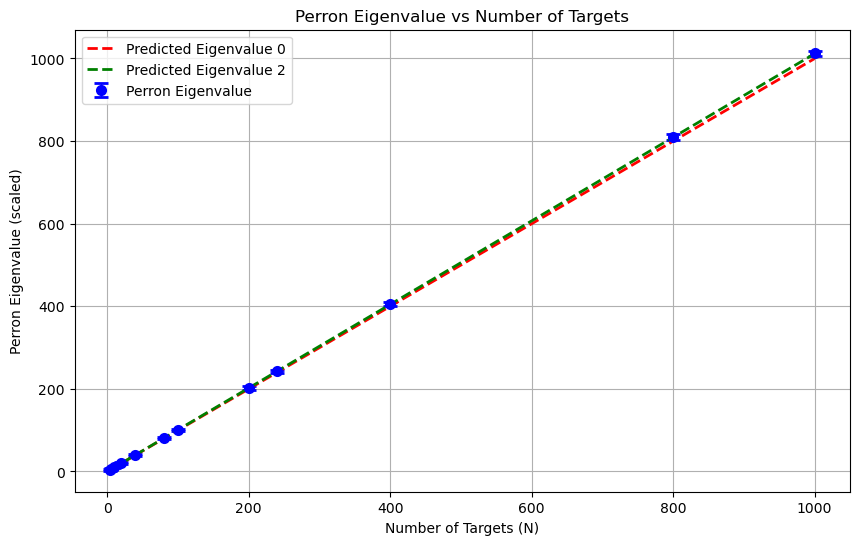

In [59]:
plt.figure(figsize=(10, 6))
plt.errorbar(n_values, eigenvalues_perron_average, yerr=eigenvalues_perron_std, 
             fmt='o', label='Perron Eigenvalue', color='blue',
             capsize=5, elinewidth=1, markeredgewidth=2)
plt.plot(n_values, predicted_pf_eigenvalues0, 'r--', label='Predicted Eigenvalue 0', linewidth=2)
plt.plot(n_values, predicted_pf_eigenvalues2, 'g--', label='Predicted Eigenvalue 2', linewidth=2)
plt.xlabel('Number of Targets (N)')
plt.ylabel('Perron Eigenvalue (scaled)')
plt.title('Perron Eigenvalue vs Number of Targets')
plt.legend()
plt.grid(True)
if create_png:
    plt.savefig('eigenvalues_perron.png', dpi=300, bbox_inches='tight')
plt.show()

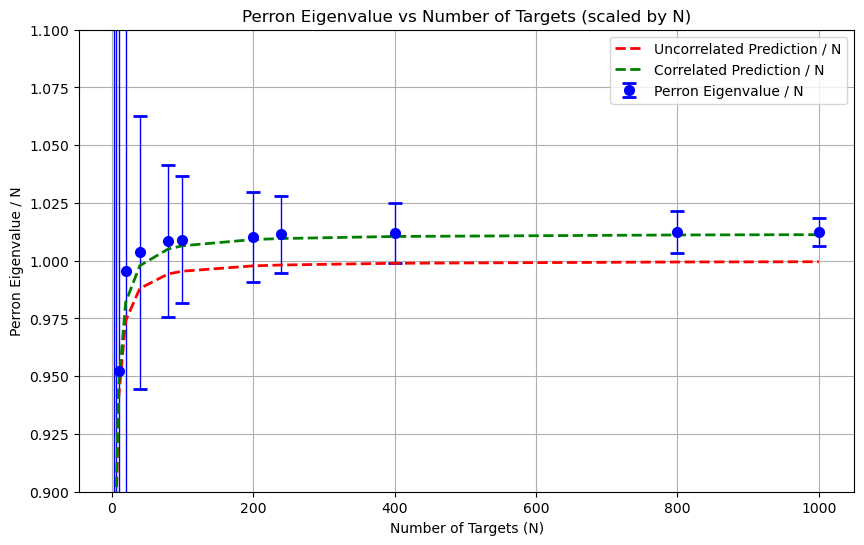

In [60]:
# plot values divided by N 
plt.figure(figsize=(10, 6))
plt.errorbar(n_values, eigenvalues_perron_average / n_values_np, 
             yerr=eigenvalues_perron_std / n_values_np,
             fmt='o', label='Perron Eigenvalue / N', color='blue',
             capsize=5, elinewidth=1, markeredgewidth=2)
plt.plot(n_values, predicted_pf_eigenvalues0 / n_values_np, 'r--', label='Uncorrelated Prediction / N', linewidth=2)
plt.plot(n_values, predicted_pf_eigenvalues2 / n_values_np, 'g--', label='Correlated Prediction / N', linewidth=2)
plt.xlabel('Number of Targets (N)')
plt.ylabel('Perron Eigenvalue / N')
plt.title('Perron Eigenvalue vs Number of Targets (scaled by N)')
plt.ylim(0.9, 1.1)  # limit y-axis to avoid too large values
plt.legend()
plt.grid(True)
if create_png:
    plt.savefig('eigenvalues_perron_scaled.png', dpi=300, bbox_inches='tight')
plt.show()